## Жерноклеев Дмитрий 
### Домашнее задание 1. Вариант 1

Показатели работы СМО, вычисленные аналитически:
1. Абсолютная  пропускная  способность СМО = 8,3076
2. Относительная пропускная способность СМО = 0,6923
3. Средняя продолжительность периода занятости СМО = 6,76129
4. Коэффициент  использования  СМО = 0,987825
5. Среднее время ожидания заявки в очереди = 0,12982 
6. Среднее время пребывания заявки в СМО = 0,3606 
7. Вероятность отказа заявке в обслуживании без ожидания = 0,3077 
8. Вероятность того, что вновь поступившая заявка немедленно будет принята к обслуживанию = 0,158215
9. Среднее число заявок, находящихся в очереди = 1,5578
10. Среднее число заявок, находящихся в СМО = 4,327

### Импортируем модули

In [1]:
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### определение самой системы (парикмахерской)

In [2]:
class Barbershop:
    def __init__(self, env, num_barbers):
        self.env = env
        self.barber = simpy.Resource(env, num_barbers)

    def haircut(self, client, mu_):
        yield self.env.timeout(np.random.exponential(scale=1 / mu_)) # 1/mu из-за реализации exponential в numpy

### "действия" заявки (клиента парикмахерской, т.е. агента, живущего в системе), при попадании в СМО

In [3]:
def barb_client(env, client, barbershop, num_chairs, mu_, total_spent_times, mean_total_spent_times_hist,
                queue_times, reject_applic, total_applic, prob_rej_hist, queue_time_hist, met_zero, p_zero_hist):   
    # заявка (клиент) приходит в систему (парикмахерскую)
    arrival_time = env.now    
    if len(barbershop.barber.users) + len(barbershop.barber.queue) == 0:
                met_zero.append(client)

    with barbershop.barber.request() as request:        
        if len(barbershop.barber.users) + len(barbershop.barber.queue) <= num_chairs + barbershop.barber.capacity: # выполняем проверку, уйдет ли заявка в отказ
            start_queue_time = env.now # момент попадания в очередь
            yield request
            queue_times.append(env.now - start_queue_time) # старт обслуживания, подсчет времени ожидания в очереди
            yield env.process(barbershop.haircut(client, mu_))
        else:
            queue_times.append(0) # в случае переполненности время ожидания ноль,
            barbershop.barber.release(request) # отказываем
            reject_applic.append(client)
    
    # клиент покидает парикмахерскую
    # подсчет показателей
    total_applic.append(client)    
    prob_rej_hist.append(len(reject_applic) / len(total_applic))
    p_zero_hist.append(len(met_zero) / len(total_applic))
    queue_time_hist.append(np.mean(queue_times)) 
    total_spent_times.append(env.now - arrival_time)
    mean_total_spent_times_hist.append(np.mean(total_spent_times))

### генерация приходящих заявок

In [4]:
def run_barbershop(env, num_barbers, num_chairs, mu_, lambda_, total_spent_times, mean_total_spent_times_hist, 
                   queue_times, reject_applic, total_applic, prob_rej_hist, queue_time_hist,
                   met_zero, p_zero_hist):
    barbershop = Barbershop(env, num_barbers)
    client = -1
    while True:
        yield env.timeout(np.random.exponential(scale=1 / lambda_))  # заявки приходят через эксп. распр. моменты 
                                                                   # с параметром лямбда
        client += 1
        env.process(barb_client(env, client, barbershop, num_chairs, mu_, total_spent_times, mean_total_spent_times_hist,
                                queue_times, reject_applic, total_applic, prob_rej_hist, queue_time_hist, 
                                met_zero, p_zero_hist))  

### функция старта симуляционных экспериментов

In [5]:
def run_func(iters=5):
    prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst = [], [], [], []
    for _ in range(iters):
        random.seed(42) # фиксируем seed
        
        lambda_ = 12 # интенсивность входного потока
        mu_ = 3 # и обслуживания
        n = 3 # число мастеров (каналов)
        N = 3 # число мест в очереди
        total_spent_times = [] # время пребывания заявки в СМО
        mean_total_spent_times_hist = [] # история среднего времени пребывания заявки в СМО
        queue_times = [] # время пребывания заявки в очереди
        reject_applic = [] # число заявок с отказом (закидываем в этот список сами завки, берем его длину)
        total_applic = [] # общее число заявок 
        prob_rej_hist = [] # история наблюдаемых значений вероятности отказа
        queue_time_hist = [] # история наблюдаемых значений среднего времени пребывания в очереди
        met_zero = [] # число заявок, заставших ноль заявок при попадании в СМО
        p_zero_hist = [] # история наблюдаемых значений pi_0

        env = simpy.Environment() # начнем симуляцию
        proc = env.process(run_barbershop(env, n, N, mu_, lambda_, 
                                          total_spent_times, mean_total_spent_times_hist, 
                                          queue_times, reject_applic, total_applic, prob_rej_hist, 
                                          queue_time_hist, met_zero, p_zero_hist))
        env.run(until=2000) # модельное время равное 2000 считаю достаточным, исходя из дальнейших шагов:
                            # графического анализа, установления факта сходимости
        prob_rej_hist_lst.append(prob_rej_hist)
        queue_time_hist_lst.append(queue_time_hist)
        mean_total_spent_times_hist_lst.append(mean_total_spent_times_hist) 
        p_zero_hist_lst.append(p_zero_hist)
    return prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst

### запуск функции старта и получение возвращаемых списков для отрисовки результатов эксперимента

In [6]:
prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst = run_func()

### функция отрисовки

In [26]:
# закоменчена функция отрисовки одного графика (т.е. без отрисовки графика разности теоретического и наблюдаемого)
# на случай, если в нижней plt_func что-то пойдет не так
# def plt_func(name, lst, theor_val, loc='lower right', gap=0.05, ylim=False):
#     gap = theor_val * gap
#     %config InlineBackend.figure_format = 'retina'
#     plt.figure(figsize=(15, 8))
#     # plt.xlabel('list ind', fontsize=12)
#     plt.ylabel('{}'.format(name), fontsize=12)
#     plt.title('График: {}'.format(name), fontsize=14)
#     if ylim:
#         plt.ylim(0, ylim)
#     for iter_num, el in enumerate(lst):
#         plt.plot(el, label=iter_num + 1)
#     plt.axhline(y=theor_val, color='r', linestyle='--', label='Теоретическое значение')
#     if gap:
#         plt.axhline(y=theor_val + gap, color='r', linestyle='-')
#         plt.axhline(y=theor_val - gap, color='r', linestyle='-')
#     plt.legend(loc=loc, title='номер эксперимента')
#     plt.show()    

def plt_func(name, lst, theor_val, loc='lower right', gap=0.05, ylim=False):
    gap = theor_val * gap
    %config InlineBackend.figure_format = 'retina'
    fig, axs = plt.subplots(2,1, figsize=(15, 16))
    axs[0].set_ylabel('{}'.format(name), fontsize=12)
    axs[0].set_title('График: {}'.format(name), fontsize=14)
    axs[1].set_title('График разности теоретического и наблюдаемого', fontsize=14)
    if ylim:
        axs[0].set_ylim(0, ylim)
    for iter_num, el in enumerate(lst):
        axs[0].plot(el, label=iter_num + 1)
        difer = np.abs(np.array(el) - theor_val * np.ones(len(el)))
        axs[1].set_ylim(0, 0.05)
        axs[1].plot(difer, label=iter_num + 1)
    axs[0].axhline(y=theor_val, color='r', linestyle='--', label='Теоретическое значение')
    if gap:
        axs[0].axhline(y=theor_val + gap, color='r', linestyle='-')
        axs[0].axhline(y=theor_val - gap, color='r', linestyle='-')
    axs[0].legend(loc=loc, title='номер эксперимента')

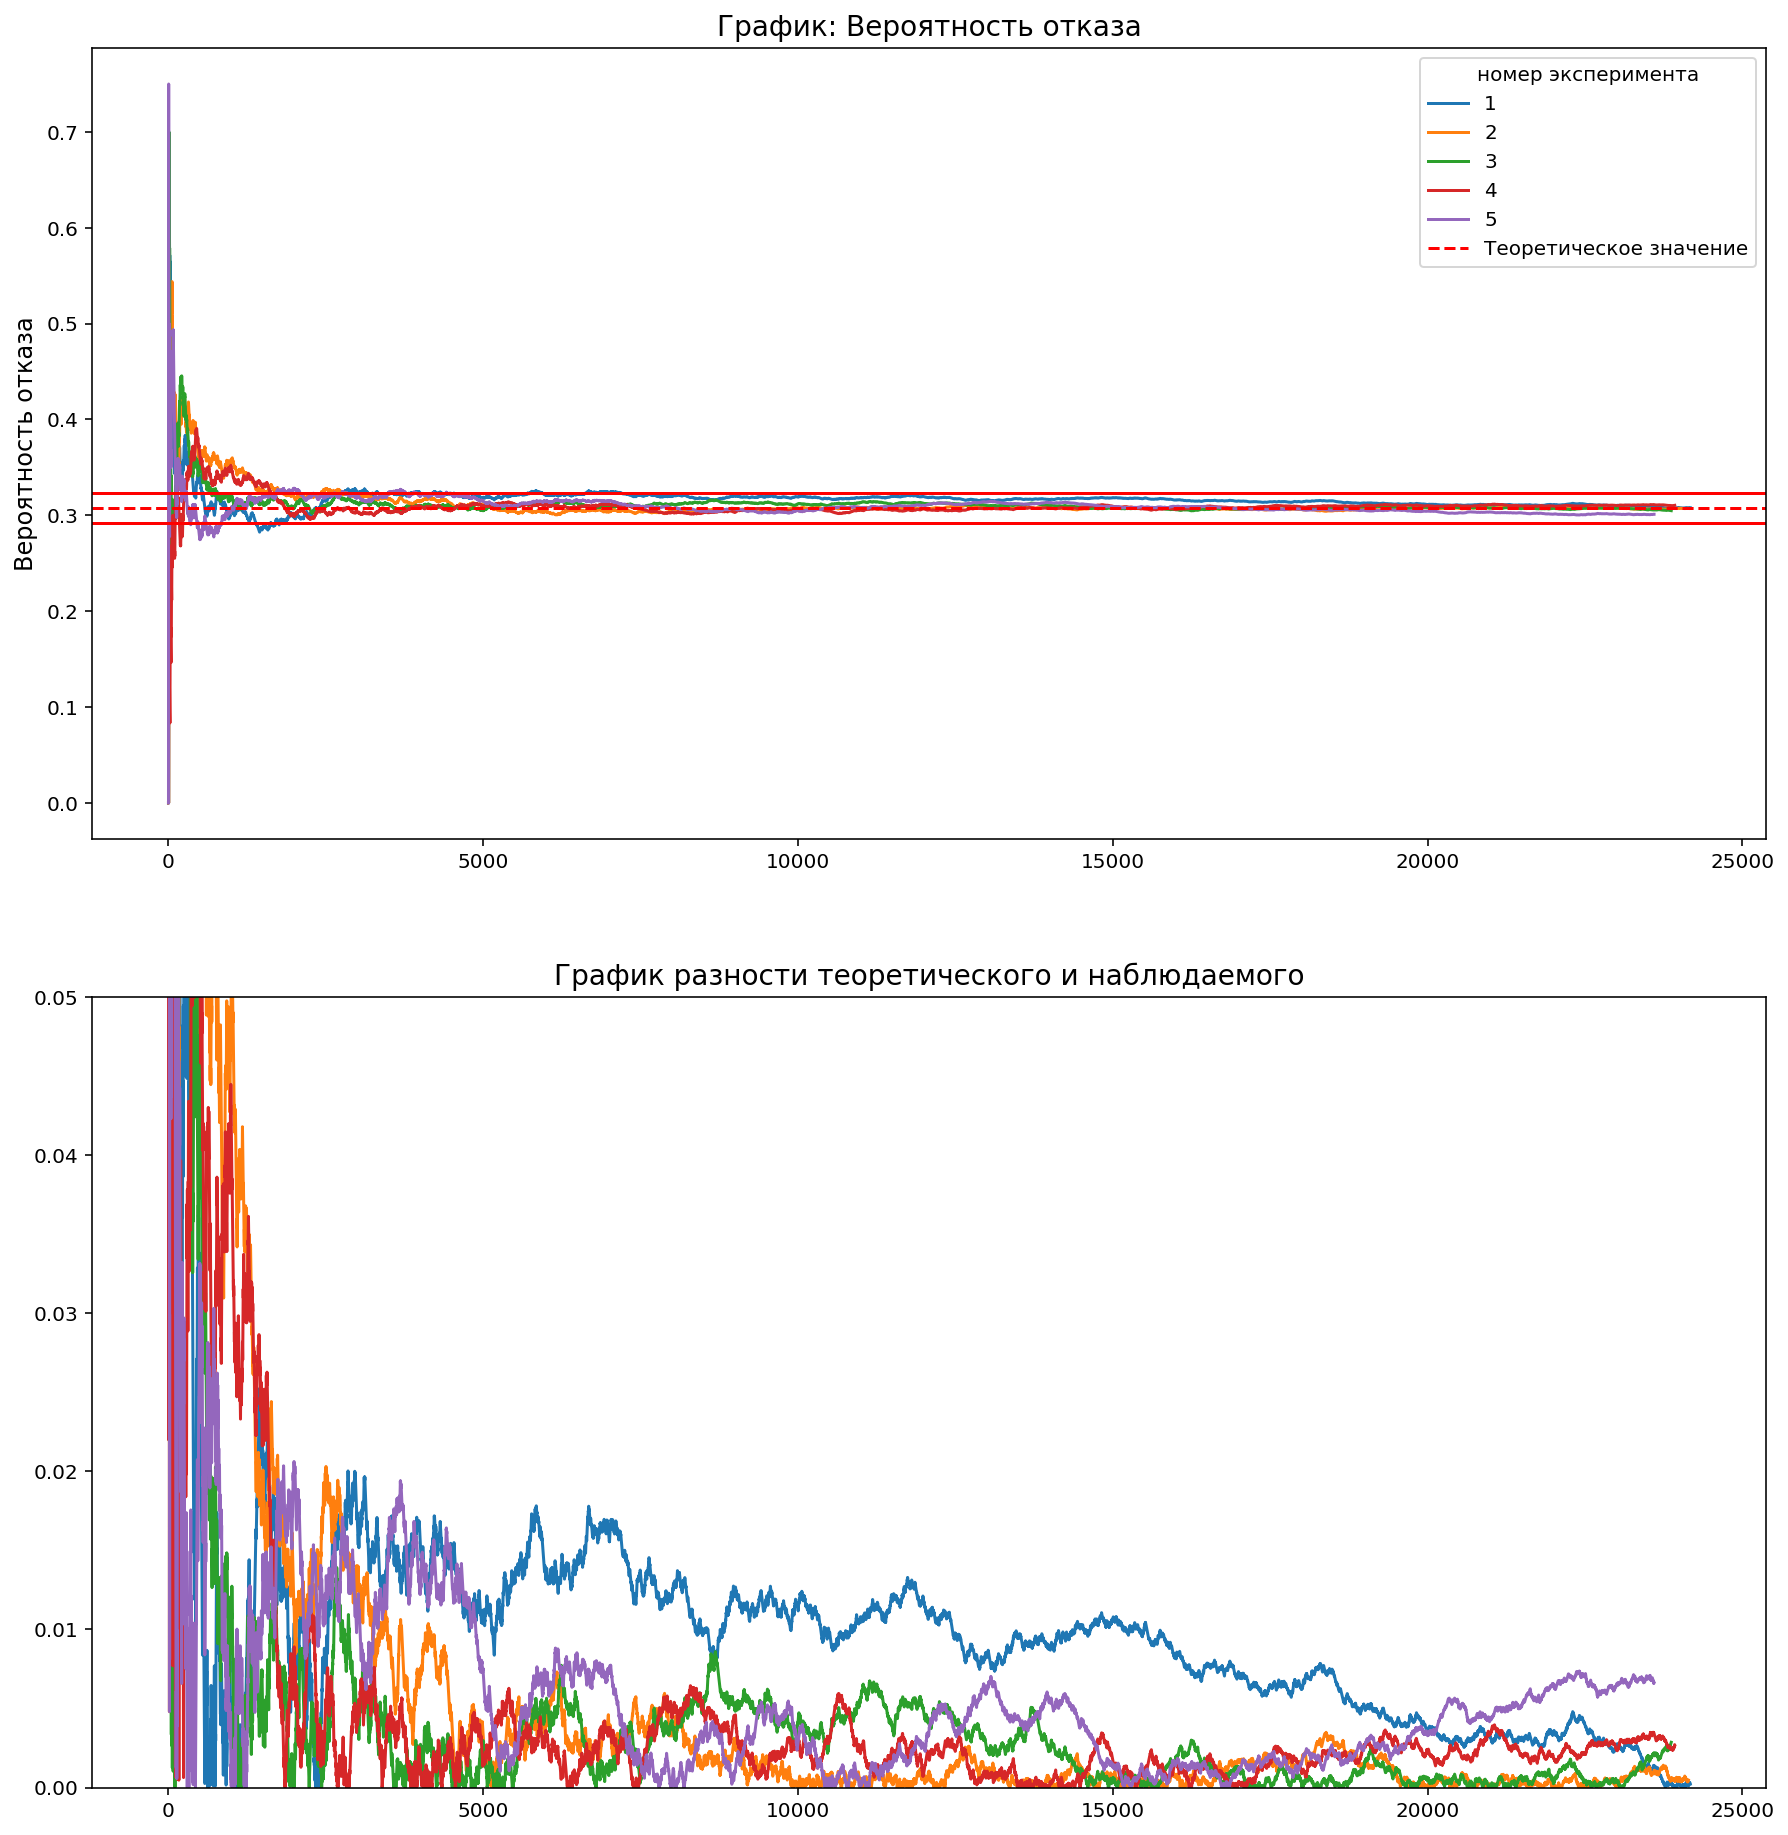

In [27]:
plt_func('Вероятность отказа', prob_rej_hist_lst, 0.3077, 'upper right')

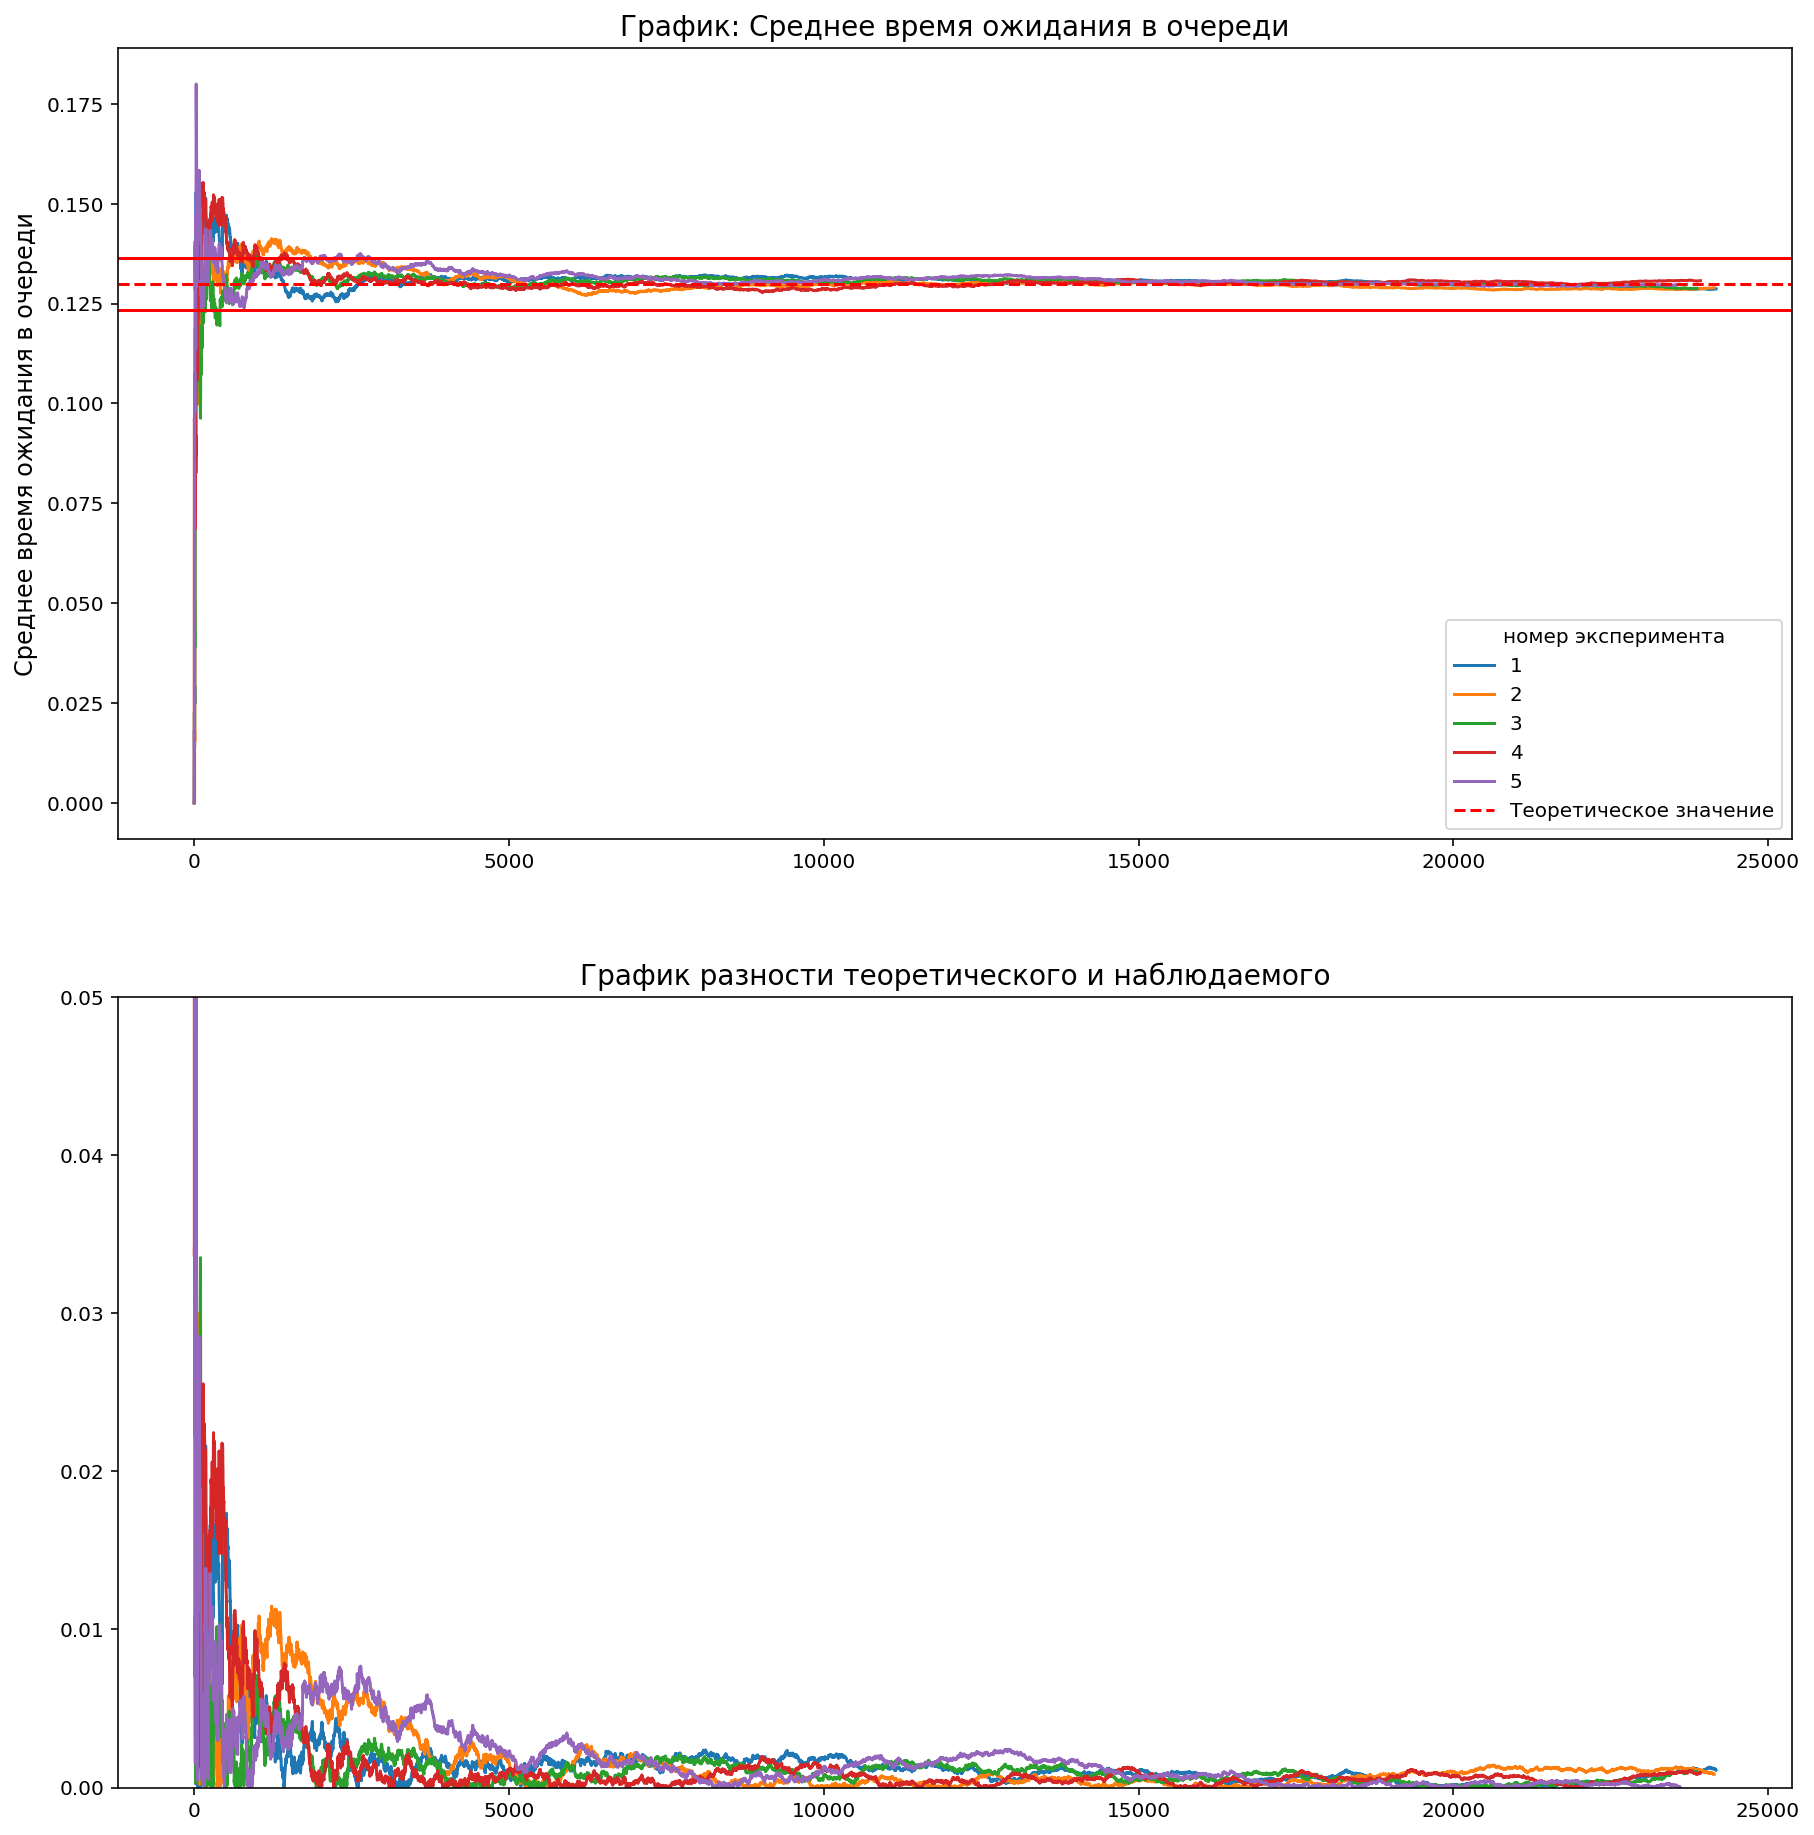

In [28]:
plt_func('Среднее время ожидания в очереди', queue_time_hist_lst, 0.12982)

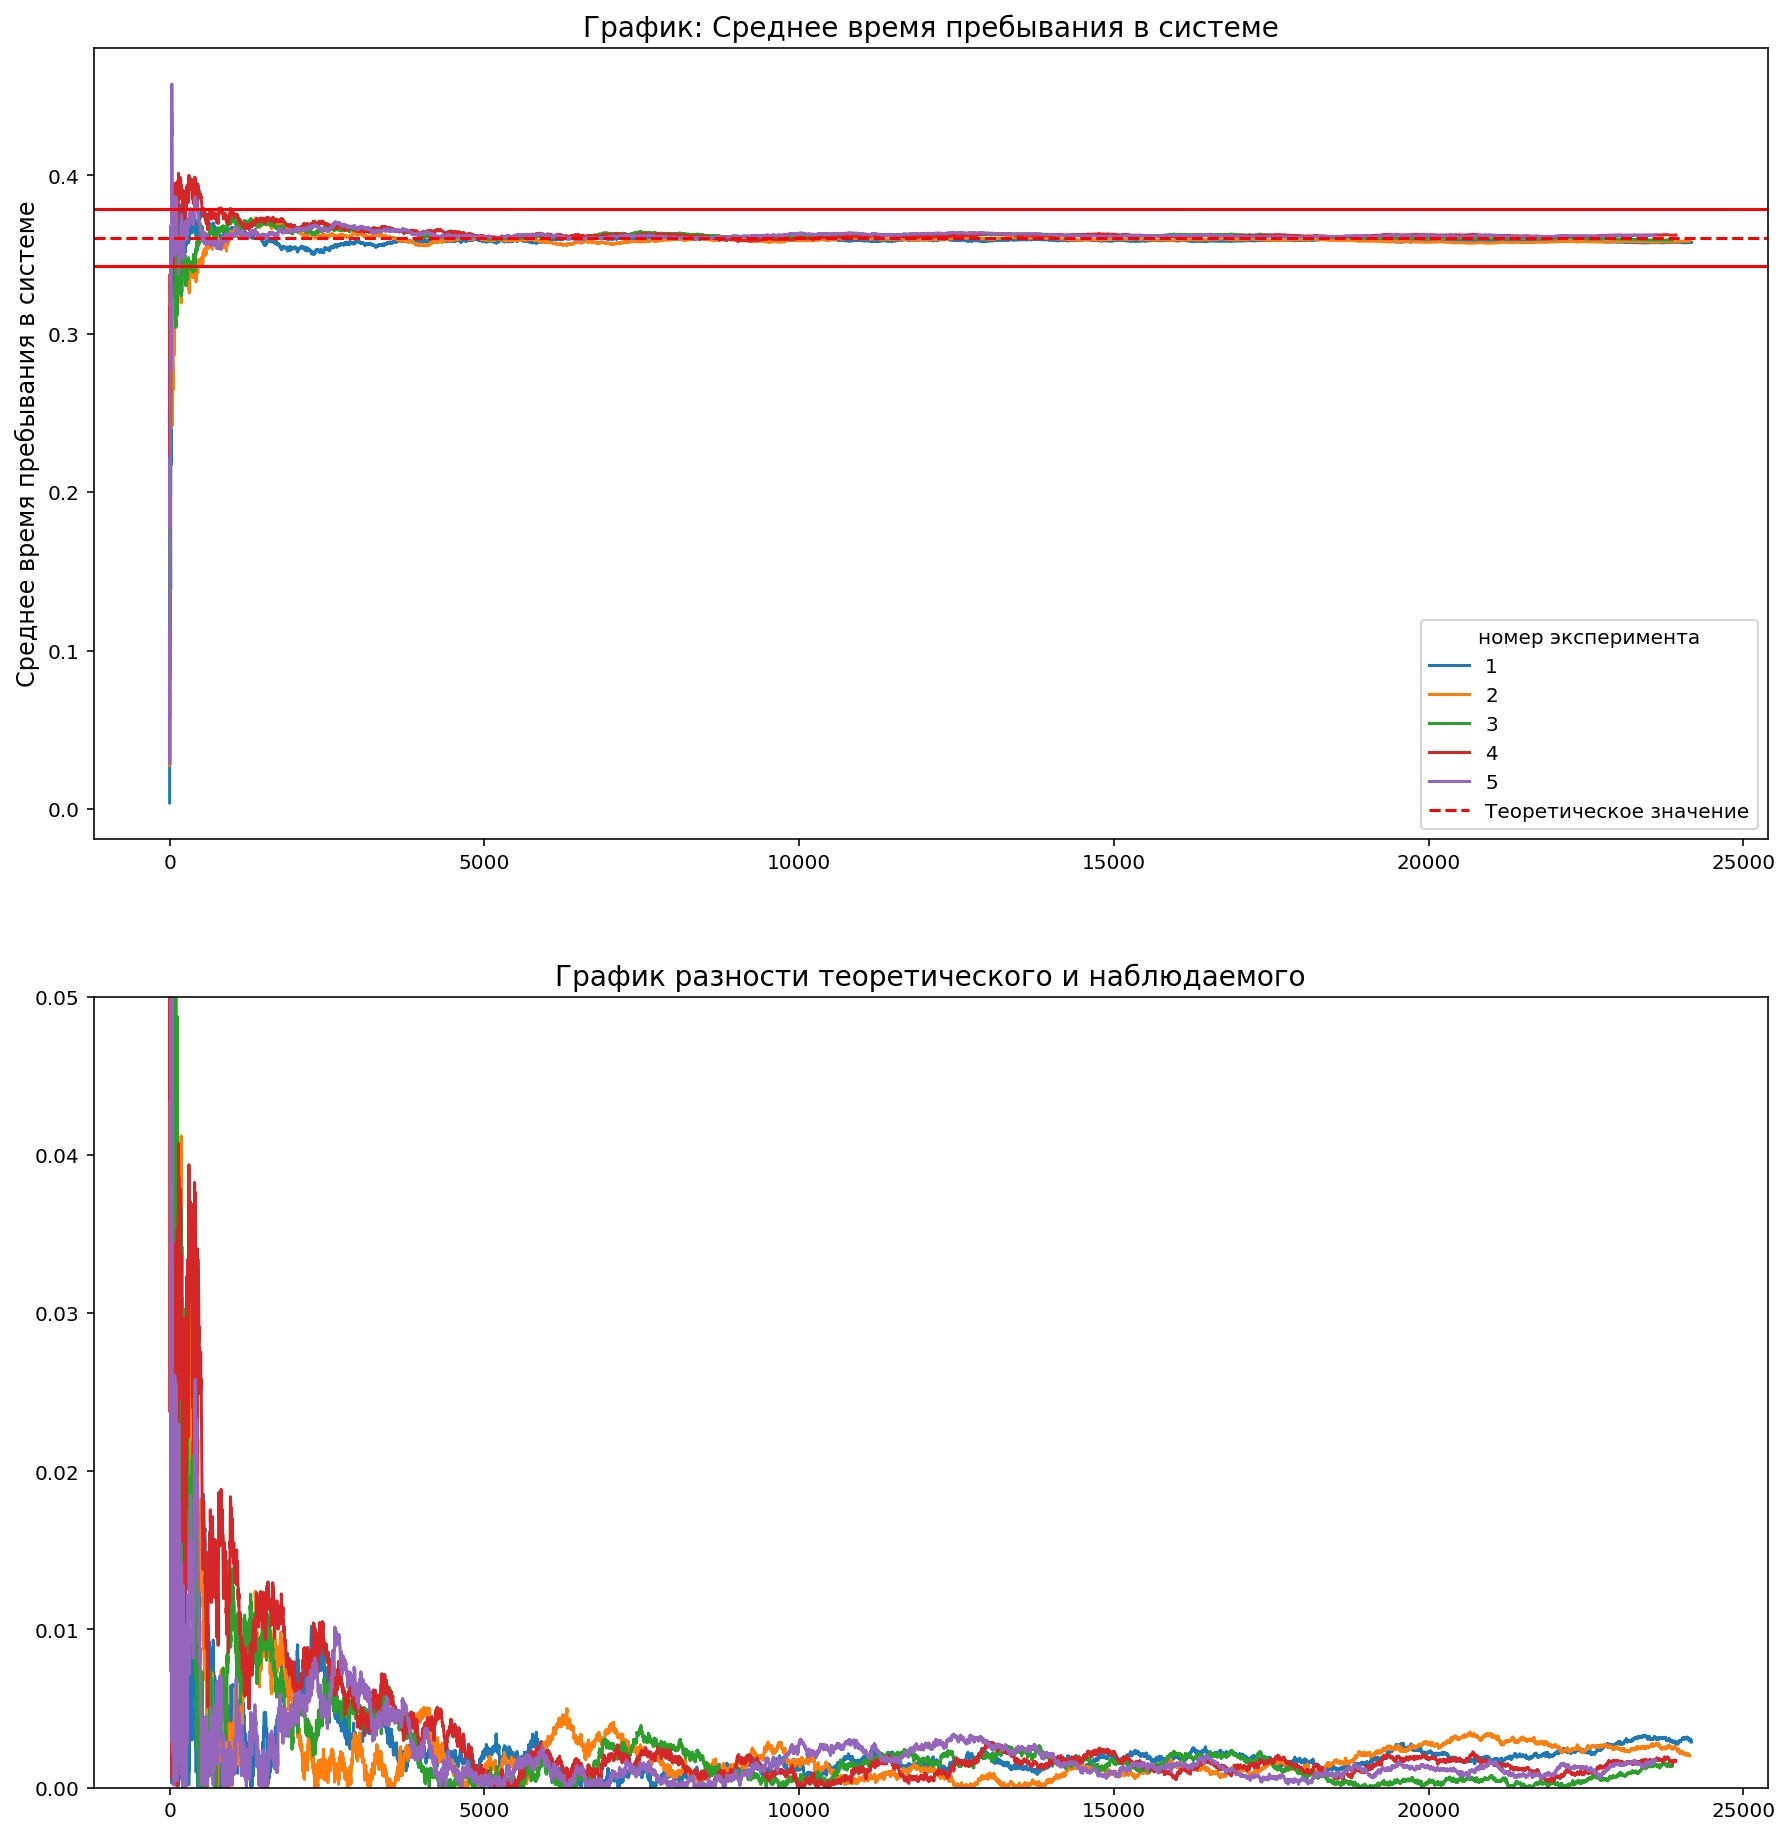

In [29]:
plt_func('Среднее время пребывания в системе', mean_total_spent_times_hist_lst, 0.3606)
# Среднее время пребывания в системе не является одним из "базовых" показателей, однако он был
# одним из первых, на которых я тестировал код, поэтому решил его оставить 

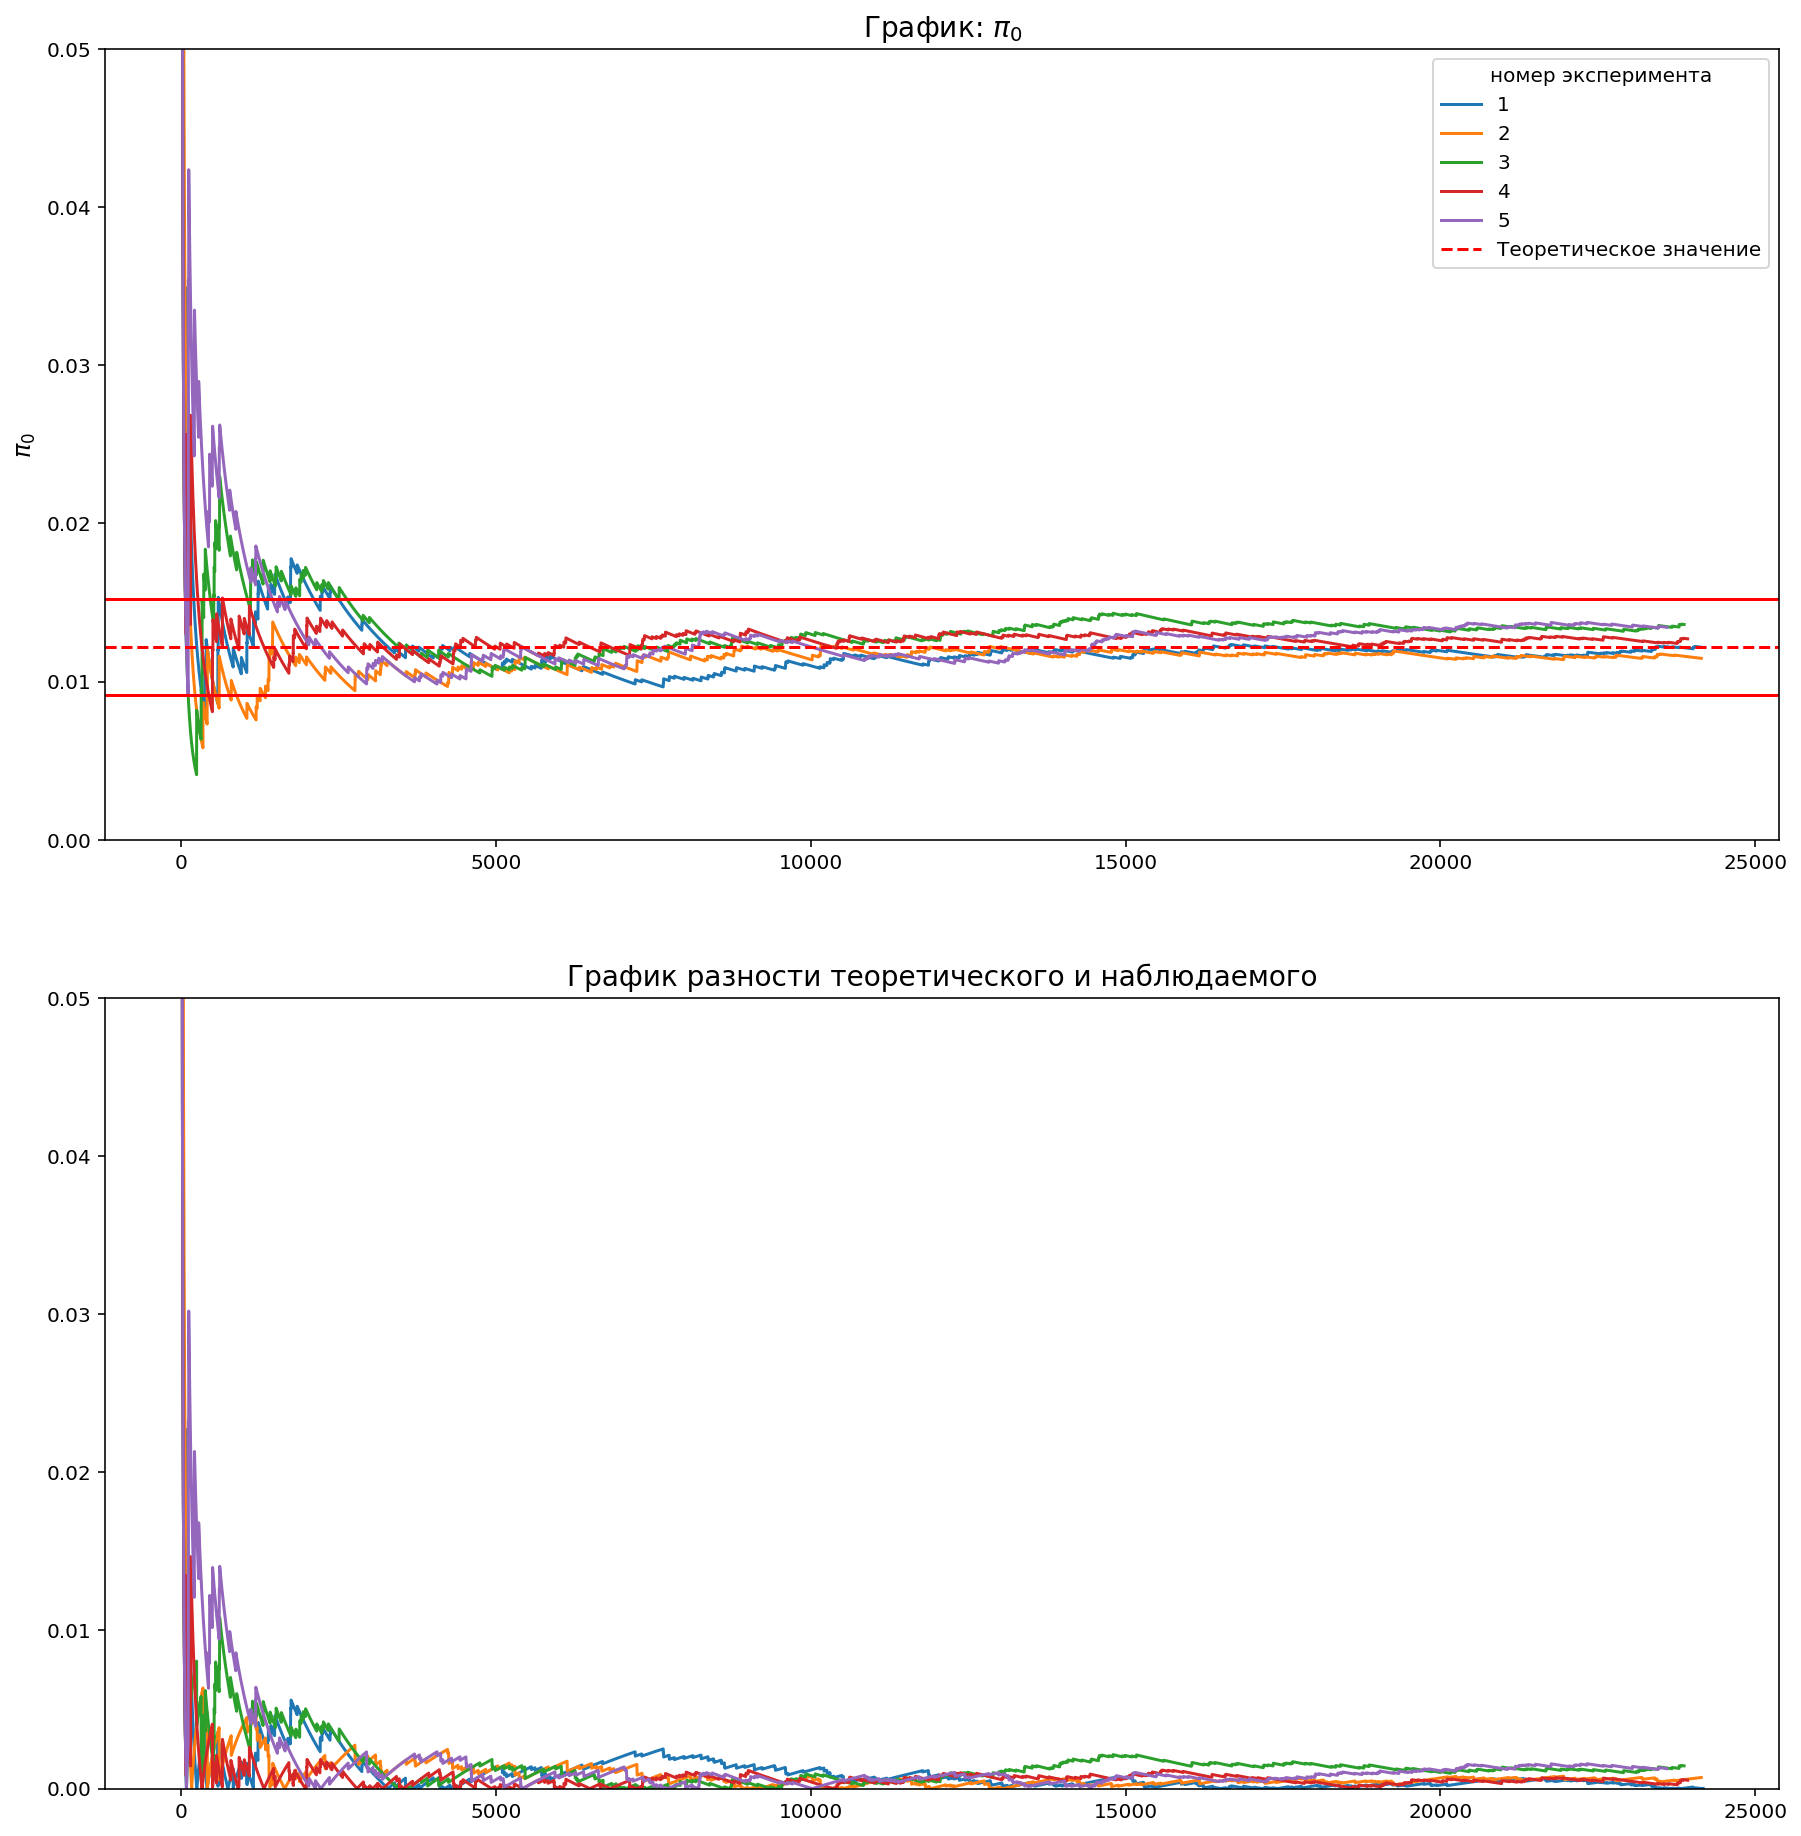

In [30]:
plt_func('$\pi_0$', p_zero_hist_lst, 0.012175, 'upper right', gap=0.25, ylim=0.05)

**Из графиков видно, что, начиная с отметки примерно 8000-10000, наблюдаемые значения для показателей, можно сказать, входят в  "стационарный режим", колеблясь вблизи теоретического значения в пределах установленного окна (сплошные линии), поэтому можем говорить о том, что наблюдается сходимость**

**Определим, проведено ли достаточное число экспериментов (стартов) по алгоритму, описанному в**  
https://cyberleninka.ru/article/n/tochnyy-metod-rascheta-neobhodimogo-kolichestva-povtornyh-opytov/viewer

In [31]:
for i, x in enumerate([prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst]):
    a = np.mean([x[i][-1] for i in range(len(x))])
    sigma = np.var([x[i][-1] for i in range(len(x))]) ** 0.5
    k_t = 0.05
    t_pr = k_t * a / sigma
    print(i + 1, ':', t_pr)

1 : 4.857838326152424
2 : 8.357118701506106
3 : 9.312931231235575
4 : 0.79636781376703


Находим по таблице t-критерия Стьюдента ближайшее меньшее относительно расчетного табличное значение. Для доверительной вероятности 0.95 оно равно: 2,4838 для первых двух случаев и 8,9845 для 3-го случая, соответствующее значение числа степеней свободы $f = 2$ (для первых двух, и $f = 3$ для третьего), поэтому минимальное число повторных экспериментов $ n_{min} = f+1 = 2+1 = 3$ (соответственно, 4 для третьего). Однако, в последнем случае (случае $\pi_0$), ближайшее меньшее табличное значение будет равно 8, поэтому минимальное число повторных экспериментов должно быть 9. Поскольку ранее было проведено 5 запусков, необходимо проведение 4 дополнительных опытов.

In [15]:
# здесь закоменчен код для проведения доп. стартов.
# prob_rej_hist_lst_add, queue_time_hist_lst_add, mean_total_spent_times_hist_lst_add, p_zero_hist_lst_add = run_func(iters=4)
# prob_rej_hist_lst += prob_rej_hist_lst_add
# queue_time_hist_lst += queue_time_hist_lst_add
# mean_total_spent_times_hist_lst += mean_total_spent_times_hist_lst_add
# p_zero_hist_lst += p_zero_hist_lst_add

**Рассчитаем оставшиеся показатели, опираясь на полученные экспериментальным путем "базовые" показатели, применяя формулы из теории, в качестве итоговых значений соответствующих показателей будем брать среднее наблюдаемых значений на момент окончания симуляции по всем стартам. Базовыми будем считать следующие показатели: вероятность отказа, среднее время пребывания в очереди, $\pi_0$, оставшиеся показатели получим из базовых, используя формулы из теории.**

In [32]:
lambda_ = 12 # здесь обозначения (названия переменных) совпадают с таковыми 
             # в письменной работе и являются общепринятыми в литературе,
             # или подписаны при выводе в данной ячейке
mu_ = 3
P_rej = np.mean([prob_rej_hist_lst[i][-1] for i in range(len(prob_rej_hist_lst))])
Q = 1 - P_rej
A = lambda_ * Q
k = A / mu_
T_mean_queue = np.mean([queue_time_hist_lst[i][-1] for i in range(len(queue_time_hist_lst))])  
L = lambda_ * T_mean_queue
M = L + k
T_mean_sys = M / lambda_
pi_0 = np.mean([p_zero_hist_lst[i][-1] for i in range(len(p_zero_hist_lst))])
U = 1 - pi_0
b = (1 - pi_0) / (lambda_ * pi_0)
print('Вероятность отказа = %.5f' % P_rej)
print('Q = %.5f' % Q)
print('A = %.5f' % A)
print('Среднее число занятых каналов = %.5f' % k)
print('Среднее время пребывания в очереди = %.5f' % T_mean_queue)
print('L = %.5f' % L)
print('M = %.5f' % M)
print('Среднее время пребывания в СМО = %.5f' % T_mean_sys)
print('Коэффициент использования СМО = %.5f' % U)
print('Средняя продолжительность периода занятости = %.5f' % b)

Вероятность отказа = 0.30629
Q = 0.69371
A = 8.32453
Среднее число занятых каналов = 2.77484
Среднее время пребывания в очереди = 0.12942
L = 1.55306
M = 4.32790
Среднее время пребывания в СМО = 0.36066
Коэффициент использования СМО = 0.98732
Средняя продолжительность периода занятости = 6.49020


**Как видим, расхождения с рассчитанными аналитическим способом показателями не так уж велики: точность в основном сохраняется до 3-4 знаков после запятой**